First step is connecting to the drive to access corpus audio files.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Generate spectrograms

The first step is to load the WAV files, use a python package named `Librosa` to generate spectrogram images from them, load the spectrograms into memory and prepare them for use in training a CNN.

In [5]:
import numpy as np
import librosa.display, os
import matplotlib.pyplot as plt
%matplotlib inline

def create_spectrogram(audio_file, image_file):
  fig = plt.figure()
  ax = fig.add_subplot(1,1,1)
  fig.subplots_adjust(left=0,right=1,bottom=0,top=1)

  y, sr = librosa.load(audio_file)
  ms = librosa.feature.melspectrogram(y=y, sr=sr)
  log_ms = librosa.power_to_db(ms, ref=np.max)
  librosa.display.specshow(log_ms, sr=sr)

  fig.savefig(image_file)
  plt.close(fig)


def create_pngs_from_wavs(input_path, output_path):
  if not os.path.exists(output_path):
    os.makedirs(output_path)

  dir = os.listdir(input_path)

  for i, file in enumerate(dir):
    input_file = os.path.join(input_path, file)
    output_file = os.path.join(output_path, file.split('.')[0] + '.png')
    if os.path.exists(output_file):
      continue
    create_spectrogram(input_file, output_file)

In [6]:
create_pngs_from_wavs(f"/content/drive/My Drive/Internship/Audio/Persuasive", f"/content/drive/My Drive/Internship/Spectrograms/Persuasive")
create_pngs_from_wavs(f"/content/drive/My Drive/Internship/Audio/NonPersuasive", f"/content/drive/My Drive/Internship/Spectrograms/NonPersuasive")

Check if the number of spectrograms corresponds to the number of audio files:

In [7]:
total_len = 0

for cat in ["Persuasive", "NonPersuasive"]:
  total_len += len(os.listdir(f'/content/drive/My Drive/Internship/Spectrograms/{cat}'))
  if len(os.listdir(f'/content/drive/My Drive/Internship/Spectrograms/{cat}')) == len(os.listdir(f'/content/drive/My Drive/Internship/Audio/{cat}')):
    print('OK')
  else:
    print('NOT OK')

print(total_len)

OK
OK
248


Declare 2 new helper function for loading and displaying spectrograms. Declare also 2 python lists (1 to store spectrogram images, 1 to store class labels).

In [8]:
from keras.preprocessing import image

def load_image_from_path(path, label):
  images = []
  labels = []

  for file in os.listdir(path):
    images.append(image.img_to_array(image.load_img(os.path.join(path, file), target_size=(224, 224, 3))))
    labels.append(label)

  return images, labels

In [9]:
def show_images(images):
  if len(images) < 8:
    fig, axes = plt.subplots(1, len(images), figsize=(20, 20), subplot_kw={'xticks':[], 'yticks':[]})
  else:
    fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks':[], 'yticks':[]})

  for i, ax in enumerate(axes.flat):
    ax.imshow(images[i] / 255)

x = []
y = []

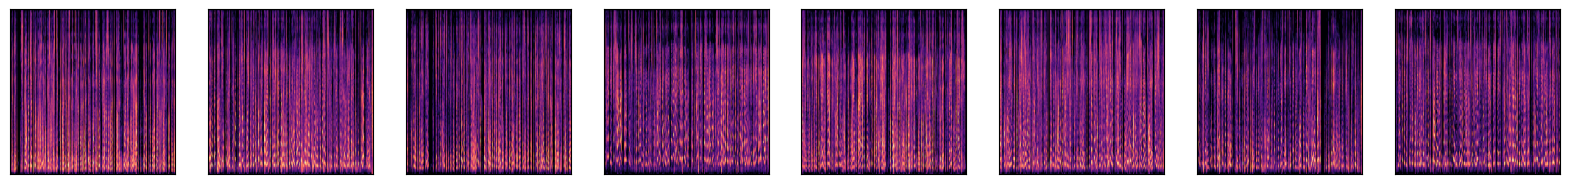

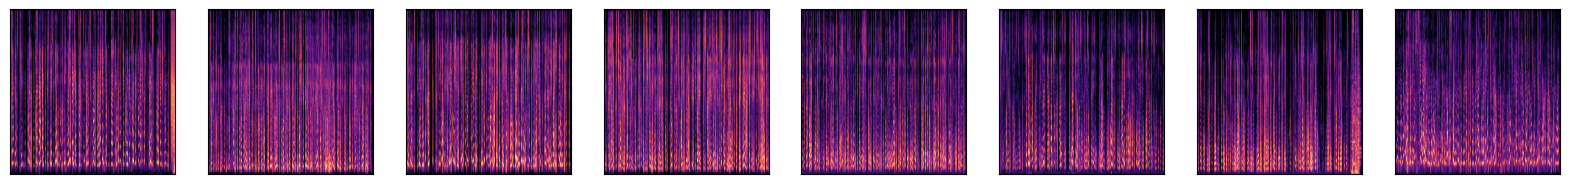

In [10]:
for cat in ['Persuasive', 'NonPersuasive']:
  images, labels = load_image_from_path(f'/content/drive/My Drive/Internship/Spectrograms/{cat}', cat)
  show_images(images)
  x += images
  y += labels

Split the images and labels into 2 datasets - one for training and one for testing. Then divide the pixel value by 255 and use Keras's `to_categorical` function.

In [13]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=0)

x_train_norm = np.array(x_train) / 255
x_test_norm = np.array(x_test) / 255

# Encode labels to numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Now you can apply to_categorical
y_train_encoded = to_categorical(y_train_encoded)
y_test_encoded = to_categorical(y_test_encoded)

#y_train_encoded = to_categorical(y_train)
#y_test_encoded = to_categorical(y_test)

## Build and train the CNN

The next step is to build a CNN containing a series of convolution and pooling layers for feature extraction, a pair of fully connected layers for classification, a softmax layer that outputs probabilities for each class, and to train it with spectrogram images and labels.

First step is defining the CNN.

In [19]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 109, 109, 128)       │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 54, 54, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 52, 52, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │      18,875,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │           2,050 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,210,498 (73.28 MB)

 Trainable params: 19,210,498 (73.28 MB)

 Non-trainable params: 0 (0.00 B)

Train the CNN and save the history object returned by fit in a local variable.

In [20]:
hist = model.fit(x_train_norm, y_train_encoded, epochs=10, validation_data=(x_test_norm, y_test_encoded), batch_size=10)

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5177 - loss: 0.8976 - val_accuracy: 0.6000 - val_loss: 0.6809
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.5864 - loss: 0.6986 - val_accuracy: 0.6000 - val_loss: 0.6728
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.5298 - loss: 0.7117 - val_accuracy: 0.6000 - val_loss: 0.6832
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.5858 - loss: 0.6930 - val_accuracy: 0.6000 - val_loss: 0.6807
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.5473 - loss: 0.6870 - val_accuracy: 0.6000 - val_loss: 0.7110
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.5781 - loss: 0.7090 - val_accuracy: 0.6000 - val_loss: 0.6800
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.6524 - loss: 0.6737 - val_accuracy: 0.6000 - val_loss: 0.6786
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.6396 - loss: 0.6842 - val_accuracy: 0.6000 - val_loss:

Plot the training and validation accuracy.

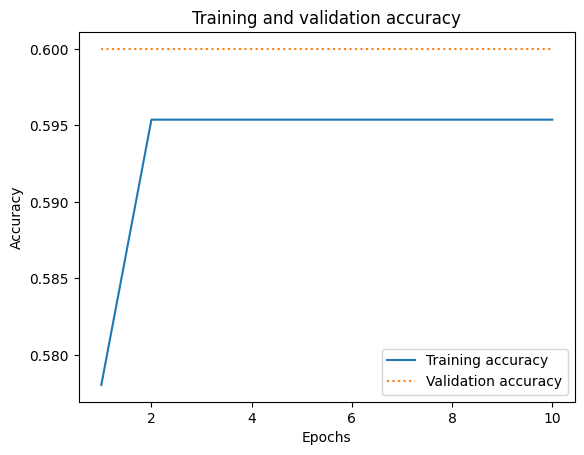

In [21]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val_acc, ':', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

## Use of transfer learning to improve accuracy

Using sophisitcated CNNs trained by Google, Microsoft, etc. to be repurposed and used to solve domain-specific problems.
Let's use `MobileNetV2`, a pretrained CNN from Google that is optimized for mobile devices, to extract features from spectrogram images.

We start by calling Keras's MobileNetV2 function to instanciante the model without the classification layers. Then we use the `preprocess_input` fnuction for MobileNet networks and run both datasets througgh MobileNetV2 to extract features.

In [22]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x_train_norm = preprocess_input(np.array(x_train))
x_test_norm = preprocess_input(np.array(x_test))

train_features = base_model.predict(x_train_norm)
test_features = base_model.predict(x_test_norm)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 704ms/step


We define a neural network to classify features extracted by MobileNetV2.

In [23]:
model = Sequential()
model.add(Flatten(input_shape=train_features.shape[1:]))
model.add(Dense(1024, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)                  │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │      64,226,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │           2,050 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,228,354 (245.01 MB)

 Trainable params: 64,228,354 (245.01 MB)

 Non-trainable params: 0 (0.00 B)

Then train the network with features extracted by `MobileNetV2`.

In [24]:
hist = model.fit(train_features, y_train_encoded, epochs=10, validation_data=(test_features, y_test_encoded), batch_size=10)

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.4749 - loss: 28.4354 - val_accuracy: 0.5333 - val_loss: 13.3221
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6728 - loss: 7.8528 - val_accuracy: 0.4000 - val_loss: 24.9407
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.6098 - loss: 10.1037 - val_accuracy: 0.5867 - val_loss: 16.2014
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7455 - loss: 4.1434 - val_accuracy: 0.5333 - val_loss: 9.5054
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8589 - loss: 1.5323 - val_accuracy: 0.4800 - val_loss: 8.9256
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9431 - loss: 0.1948 - val_accuracy: 0.5200 - val_loss: 9.1619
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9832 - loss: 0.0301 - val_accuracy: 0.5467 - val_loss: 8.9108
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9926 - loss: 0.0136 - val_accuracy: 0.5333 - val_

We plot the training and validation accuracy.

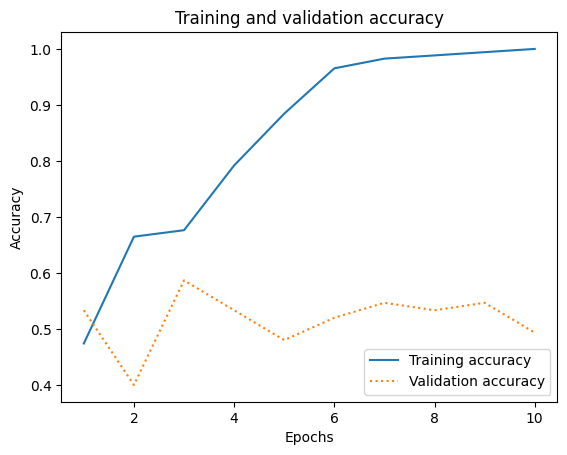

In [25]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val_acc, ':', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

We run the test images through the network and use a confusion matrix to assess the results.

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step


Text(109.44999999999997, 0.5, 'True label')

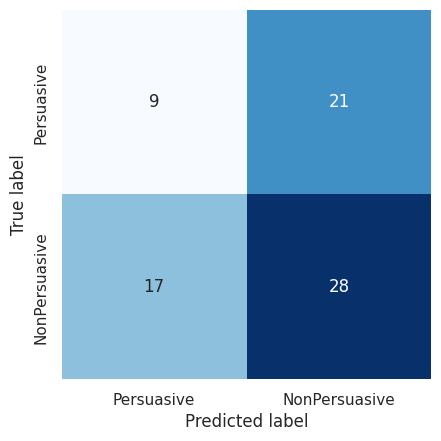

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set()

y_predicted = model.predict(test_features)
mat = confusion_matrix(y_test_encoded.argmax(axis=1), y_predicted.argmax(axis=1))
class_labels = ['Persuasive', 'NonPersuasive']
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')